# MMM EDA and Feature Preparation

## Objectives
This notebook performs exploratory data analysis (EDA) and feature engineering for Marketing Mix Modeling (MMM). We will:

1. **Load and inspect** the weekly marketing data
2. **Analyze data quality** - missing values, data types, basic statistics
3. **Visualize time series** patterns for revenue and media channels
4. **Decompose seasonality** to understand weekly patterns
5. **Analyze spending patterns** including zero-spend periods
6. **Explore correlations** between media channels and revenue
7. **Engineer features** using adstock and saturation transformations

The goal is to understand the data structure and prepare features for causal inference modeling.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from pathlib import Path
import sys

# Add src to path for module imports
sys.path.append('../src')

# Import custom modules
from preprocess import preprocess_data, load_weekly_data, generate_sample_mmm_data
from features import build_features

# Set plotting style
plt.style.use('default')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

print("✓ Libraries imported successfully")
print("✓ Custom modules loaded")

✓ Libraries imported successfully
✓ Custom modules loaded


## 1. Data Loading

Load the weekly marketing data using our custom preprocessing module. The data should contain:
- Weekly date column
- Revenue metrics
- Media channel spend data (Facebook, TikTok, Snapchat, Google)
- Promotional activity data

**Note**: Update the data path below to point to your actual data file (zip or CSV).

In [2]:
# Data loading configuration
DATA_PATH = "../data/weekly_data.zip"  # Update this path to your actual data file

# Alternative: if you have a CSV file directly
# DATA_PATH = "../data/weekly_data.csv"

# Check if data file exists
data_file = Path(DATA_PATH)
if data_file.exists():
    print(f"✓ Data file found: {DATA_PATH}")
    
    # Load data using our preprocessing pipeline
    try:
        if DATA_PATH.endswith('.zip'):
            # Use full preprocessing pipeline for zip files
            df, main_csv_path = preprocess_data(DATA_PATH, save_cleaned=True)
            print(f"✓ Data loaded from zip: {main_csv_path}")
        else:
            # Load CSV directly
            df = load_weekly_data(DATA_PATH)
            print(f"✓ Data loaded from CSV: {DATA_PATH}")
            
    except Exception as e:
        print(f"✗ Error loading data: {e}")
        print("Creating sample data for demonstration...")
        
        # Create sample data for demonstration
        from datetime import datetime
        np.random.seed(42)
        start_date = datetime(2023, 1, 1)
        weeks = pd.date_range(start_date, periods=104, freq='W')  # 2 years of data
        
        df = pd.DataFrame({
            'week': weeks,
            'revenue': np.random.lognormal(11, 0.3, 104) * 1000,  # ~$60k avg revenue
            'facebook_spend': np.random.exponential(5000, 104),
            'tiktok_spend': np.random.exponential(3000, 104),
            'snapchat_spend': np.random.exponential(2000, 104),
            'google_spend': np.random.exponential(8000, 104),
            'promotions': np.random.poisson(2, 104),
        })
        print("✓ Sample data created for demonstration")
        
else:
    print(f"⚠ Data file not found: {DATA_PATH}")
    print("Creating sample data for demonstration...")
    
    # Create sample data for demonstration
    from datetime import datetime
    np.random.seed(42)
    start_date = datetime(2023, 1, 1)
    weeks = pd.date_range(start_date, periods=104, freq='W')  # 2 years of data
    
    df = pd.DataFrame({
        'week': weeks,
        'revenue': np.random.lognormal(11, 0.3, 104) * 1000,  # ~$60k avg revenue
        'facebook_spend': np.random.exponential(5000, 104),
        'tiktok_spend': np.random.exponential(3000, 104),
        'snapchat_spend': np.random.exponential(2000, 104),
        'google_spend': np.random.exponential(8000, 104),
        'promotions': np.random.poisson(2, 104),
    })
    print("✓ Sample data created for demonstration")

print(f"\nDataset loaded with shape: {df.shape}")

2025-09-14 11:12:59,667 - INFO - Starting data preprocessing pipeline...
2025-09-14 11:12:59,670 - INFO - Extracting zip file: ../data/weekly_data.zip
2025-09-14 11:12:59,670 - INFO - Extracting zip file: ../data/weekly_data.zip
2025-09-14 11:12:59,678 - INFO - Extracted: Assessment 2 - MMM Weekly.csv
2025-09-14 11:12:59,679 - INFO - Extracted: __MACOSX/._Assessment 2 - MMM Weekly.csv
2025-09-14 11:12:59,681 - INFO - Found 1 CSV files, detecting main weekly data...
2025-09-14 11:12:59,678 - INFO - Extracted: Assessment 2 - MMM Weekly.csv
2025-09-14 11:12:59,679 - INFO - Extracted: __MACOSX/._Assessment 2 - MMM Weekly.csv
2025-09-14 11:12:59,681 - INFO - Found 1 CSV files, detecting main weekly data...
2025-09-14 11:12:59,689 - INFO - Detected main weekly CSV: Assessment 2 - MMM Weekly.csv
2025-09-14 11:12:59,690 - INFO - Loading CSV file: data/Assessment 2 - MMM Weekly.csv
2025-09-14 11:12:59,693 - INFO - Parsing date columns: ['week']
2025-09-14 11:12:59,689 - INFO - Detected main wee

✓ Data file found: ../data/weekly_data.zip

Dataset Shape: (104, 12)
Rows: 104, Columns: 12

=== FIRST 5 ROWS ===
        week  facebook_spend  google_spend  tiktok_spend  instagram_spend  \
0 2023-09-17         6030.80       3130.14       2993.22          1841.08   
1 2023-09-24         5241.44       2704.00          0.00             0.00   
2 2023-10-01         5893.00          0.00          0.00             0.00   
3 2023-10-08         7167.16          0.00          0.00             0.00   
4 2023-10-15         5360.29          0.00          0.00          3237.15   

   snapchat_spend  social_followers  average_price  promotions  emails_send  \
0         2204.72                 0         101.95           0       102684   
1            0.00                 0         103.86           0        96573   
2            0.00                 0         100.38           0        96797   
3            0.00                 0         103.14           1        99098   
4            0.00           

## 2. Data Quality Assessment

Examine the basic properties of our dataset including shape, data types, missing values, and basic statistics.

In [3]:
# Dataset overview
print("=== DATASET OVERVIEW ===")
print(f"Shape: {df.shape[0]:,} rows × {df.shape[1]} columns")
print(f"Date range: {df['week'].min()} to {df['week'].max()}")
print(f"Time span: {(df['week'].max() - df['week'].min()).days} days")

# Data types
print("\n=== DATA TYPES ===")
print(df.dtypes)

# Missing values analysis
print("\n=== MISSING VALUES ===")
missing_analysis = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})
missing_analysis = missing_analysis[missing_analysis['Missing Count'] > 0]

if not missing_analysis.empty:
    print(missing_analysis)
else:
    print("✓ No missing values found")

# Basic statistics
print("\n=== DESCRIPTIVE STATISTICS ===")
print(df.describe().round(2))

=== DATASET OVERVIEW ===
Shape: 104 rows × 12 columns
Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00
Time span: 721 days

=== DATA TYPES ===
week                datetime64[ns]
facebook_spend             float64
google_spend               float64
tiktok_spend               float64
instagram_spend            float64
snapchat_spend             float64
social_followers             int64
average_price              float64
promotions                   int64
emails_send                  int64
sms_send                     int64
revenue                    float64
dtype: object

=== MISSING VALUES ===
✓ No missing values found

=== DESCRIPTIVE STATISTICS ===
                      week  facebook_spend  google_spend  tiktok_spend  \
count                  104          104.00        104.00        104.00   
mean   2024-09-11 12:00:00         5346.30       1543.87        955.63   
min    2023-09-17 00:00:00         2456.94          0.00          0.00   
25%    2024-03-15 06:00:00         4538

In [4]:
# Display first and last few rows
print("=== FIRST 5 ROWS ===")
display(df.head())

print("\n=== LAST 5 ROWS ===")
display(df.tail())

=== FIRST 5 ROWS ===


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
0,2023-09-17,6030.80,3130.14,2993.22,1841.08,2204.72,0,101.95,0,102684,20098,83124.16
1,2023-09-24,5241.44,2704.00,0.00,0.00,0.00,0,103.86,0,96573,29920,373.02
2,2023-10-01,5893.00,0.00,0.00,0.00,0.00,0,100.38,0,96797,22304,513.01
3,2023-10-08,7167.16,0.00,0.00,0.00,0.00,0,103.14,1,99098,14171,452.78
4,2023-10-15,5360.29,0.00,0.00,3237.15,0.00,0,107.76,1,120754,30207,41441.95



=== LAST 5 ROWS ===


,week,facebook_spend,google_spend,tiktok_spend,instagram_spend,snapchat_spend,social_followers,average_price,promotions,emails_send,sms_send,revenue
99,2025-08-10,4103.29,0.0,2546.4,0.00,1987.81,137218,93.05,0,132583,26178,950.45
100,2025-08-17,7929.61,0.0,3342.8,2410.68,1432.37,138794,96.91,0,92396,39918,170470.10
101,2025-08-24,4090.74,0.0,0.0,2231.40,1666.77,140404,94.88,0,121519,16819,193527.33
102,2025-08-31,4116.70,0.0,0.0,782.06,0.00,141670,95.56,0,111165,25311,65119.20
103,2025-09-07,4795.53,0.0,0.0,0.00,0.00,143477,93.65,0,93768,34203,864.10


## 3. Time Series Visualization

Visualize the time series patterns for revenue and media channel spending to understand trends, seasonality, and spending patterns over time.

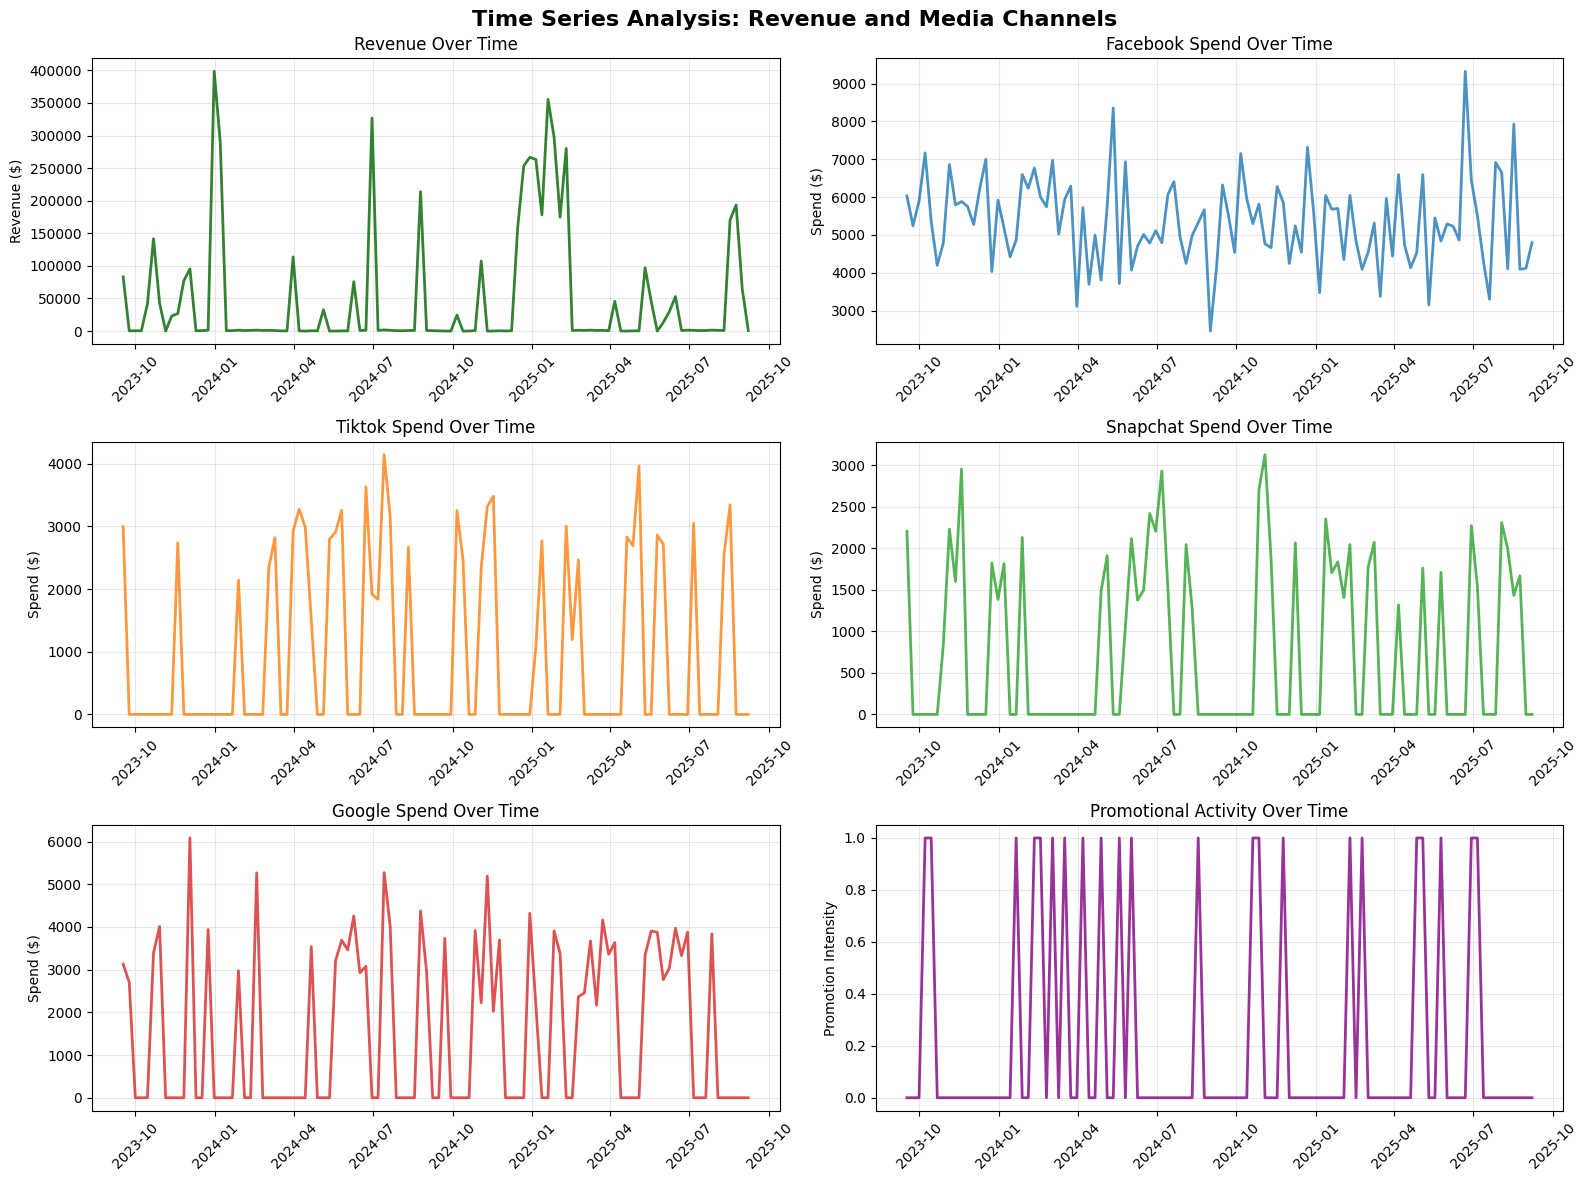

In [5]:
# Create time series plots
fig, axes = plt.subplots(3, 2, figsize=(16, 12))
fig.suptitle('Time Series Analysis: Revenue and Media Channels', fontsize=16, fontweight='bold')

# Revenue plot
axes[0, 0].plot(df['week'], df['revenue'], linewidth=2, alpha=0.8, color='darkgreen')
axes[0, 0].set_title('Revenue Over Time')
axes[0, 0].set_ylabel('Revenue ($)')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].tick_params(axis='x', rotation=45)

# Media channels
media_channels = ['facebook_spend', 'tiktok_spend', 'snapchat_spend', 'google_spend']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, (channel, color) in enumerate(zip(media_channels, colors)):
    if channel in df.columns:
        row = (i + 1) // 2
        col = (i + 1) % 2
        
        axes[row, col].plot(df['week'], df[channel], linewidth=2, alpha=0.8, color=color)
        axes[row, col].set_title(f'{channel.replace("_", " ").title()} Over Time')
        axes[row, col].set_ylabel('Spend ($)')
        axes[row, col].grid(True, alpha=0.3)
        axes[row, col].tick_params(axis='x', rotation=45)

# Promotions (if available)
if 'promotions' in df.columns:
    axes[2, 1].plot(df['week'], df['promotions'], linewidth=2, alpha=0.8, color='purple')
    axes[2, 1].set_title('Promotional Activity Over Time')
    axes[2, 1].set_ylabel('Promotion Intensity')
    axes[2, 1].grid(True, alpha=0.3)
    axes[2, 1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

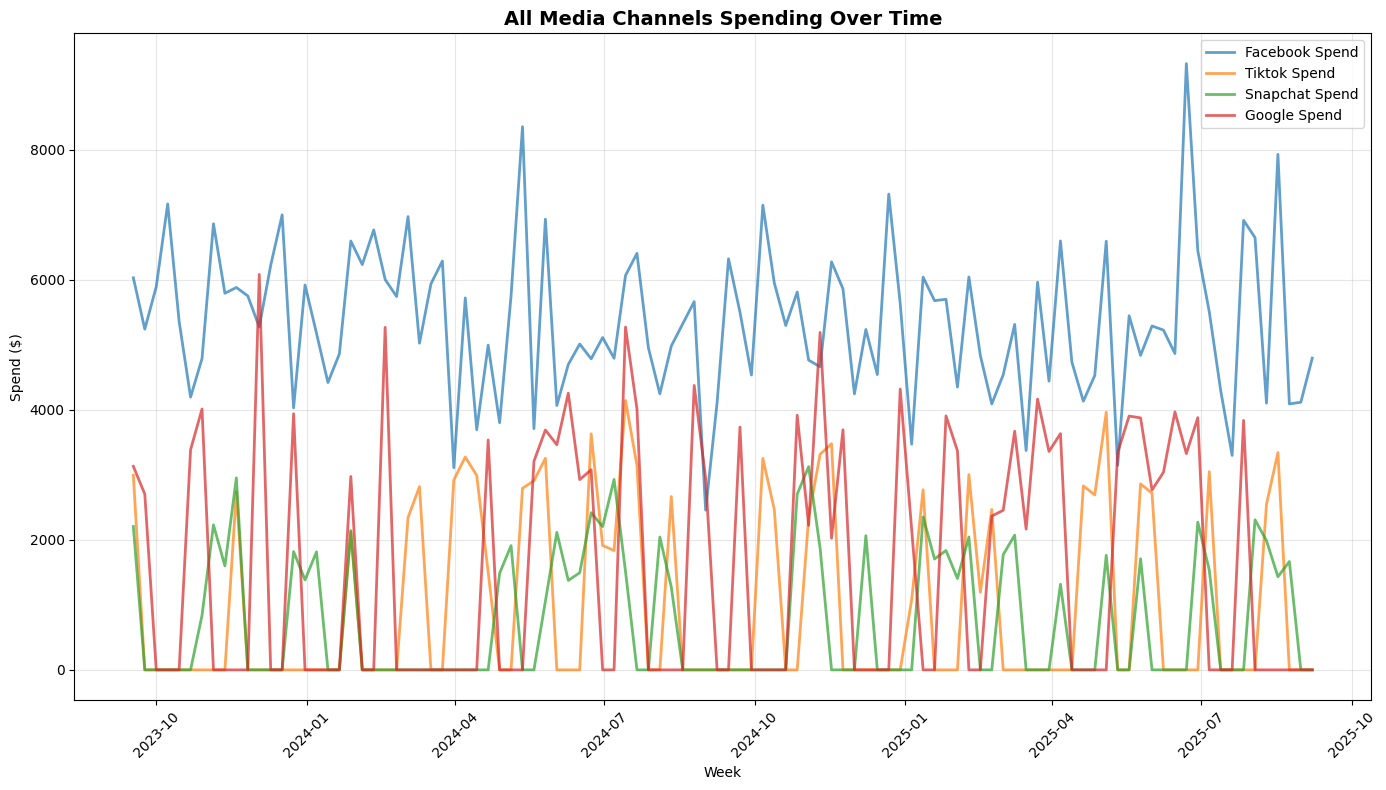

=== TIME SERIES SUMMARY STATISTICS ===
         revenue  facebook_spend  tiktok_spend  snapchat_spend  google_spend  \
count     104.00          104.00        104.00          104.00        104.00   
mean    49053.95         5346.30        955.63          747.46       1543.87   
std     93329.61         1168.96       1376.99          982.09       1863.35   
min         1.00         2456.94          0.00            0.00          0.00   
25%       474.85         4538.98          0.00            0.00          0.00   
50%       972.06         5293.78          0.00            0.00          0.00   
75%     45773.73         6033.32       2487.17         1705.87       3374.20   
max    398453.53         9325.18       4143.25         3126.04       6083.16   

       promotions  
count      104.00  
mean         0.21  
std          0.41  
min          0.00  
25%          0.00  
50%          0.00  
75%          0.00  
max          1.00  


In [6]:
# Combined media spending plot
plt.figure(figsize=(14, 8))

# Plot all media channels on same axis
for i, (channel, color) in enumerate(zip(media_channels, colors)):
    if channel in df.columns:
        plt.plot(df['week'], df[channel], 
                linewidth=2, alpha=0.7, color=color, 
                label=channel.replace('_', ' ').title())

plt.title('All Media Channels Spending Over Time', fontsize=14, fontweight='bold')
plt.xlabel('Week')
plt.ylabel('Spend ($)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Summary statistics for time series
print("=== TIME SERIES SUMMARY STATISTICS ===")
ts_summary = df[['revenue'] + media_channels + (['promotions'] if 'promotions' in df.columns else [])].describe()
print(ts_summary.round(2))

## 4. Seasonality Decomposition

Decompose the revenue time series to understand trend, seasonality, and residual components. This helps identify weekly patterns that might influence marketing effectiveness.

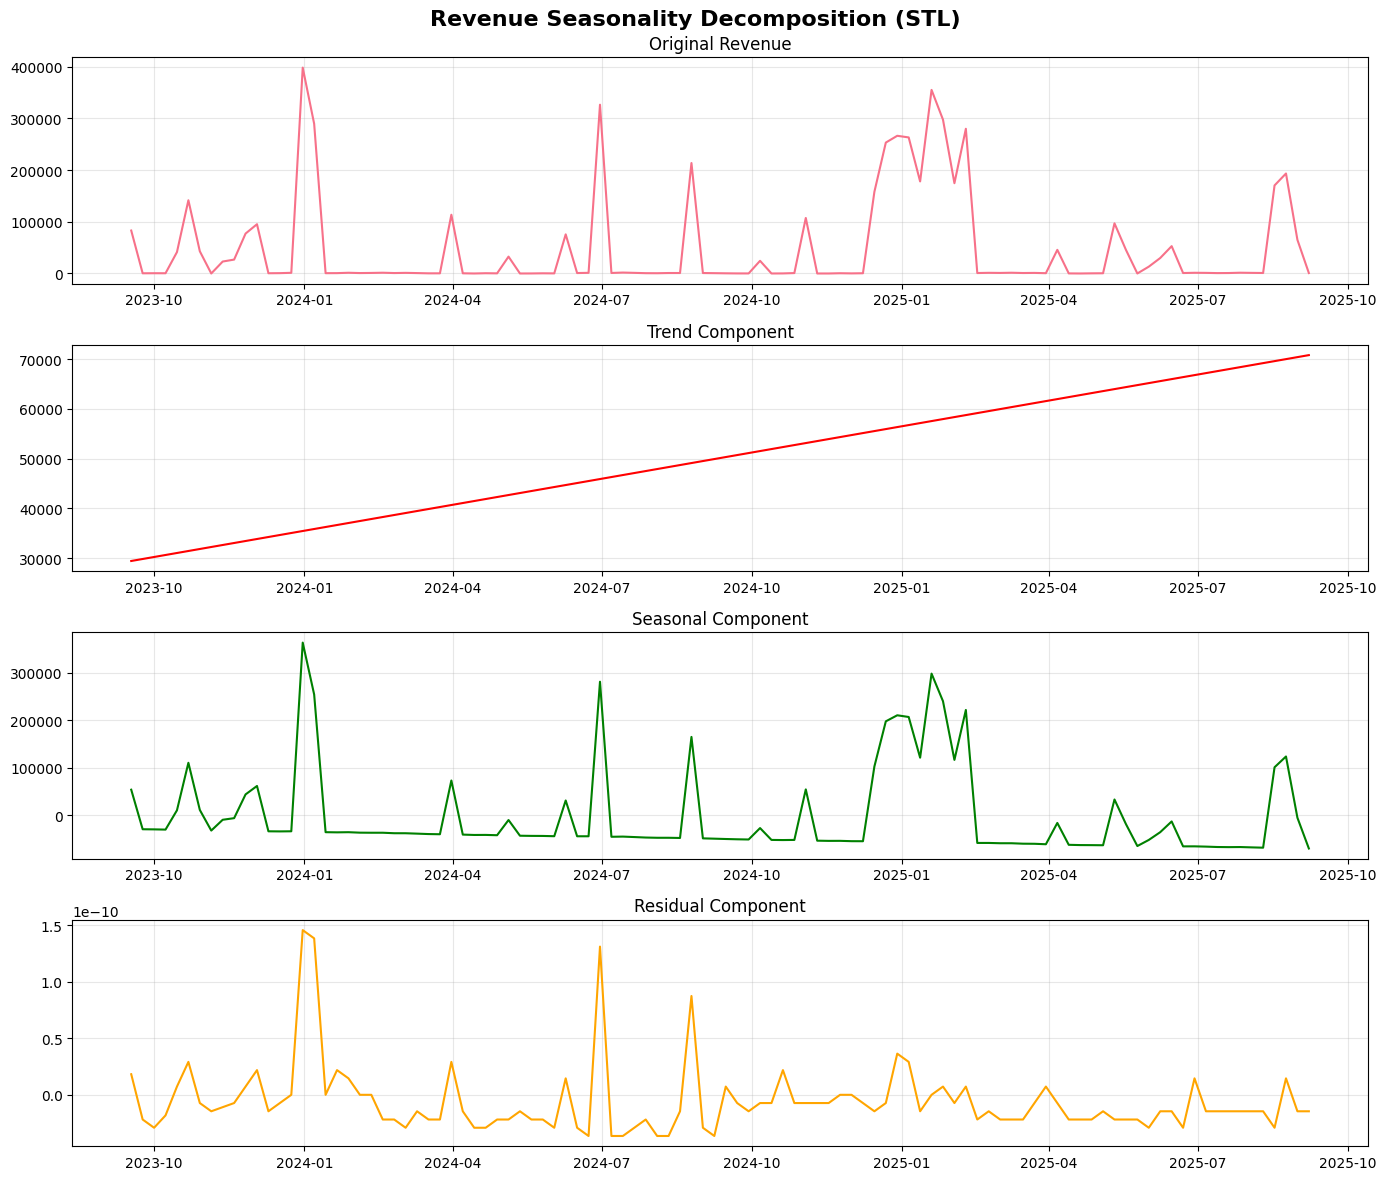

=== WEEKLY SEASONALITY PATTERN ===
Average seasonal effect by week of year (top 10 highest):
week
52    286595.75
1     230253.02
34    144119.63
3     130912.62
26    107680.38
4     102077.43
6      92273.70
51     81861.39
2      42685.54
5      39866.23
Name: season, dtype: float64

Average seasonal effect by week of year (top 10 lowest):
week
36   -59601.56
32   -57811.77
31   -57496.71
30   -56891.85
29   -56480.87
28   -55875.05
27   -55648.45
25   -54858.71
21   -54148.48
17   -52452.33
Name: season, dtype: float64


In [7]:
# Seasonal decomposition of revenue
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

# Ensure we have enough data points for decomposition
if len(df) >= 52:  # At least 1 year of weekly data
    
    # Set week as index for decomposition
    df_ts = df.set_index('week')['revenue']
    
    # Perform seasonal decomposition
    try:
        # Try STL decomposition first (more robust)
        try:
            from statsmodels.tsa.seasonal import STL
            stl = STL(df_ts, seasonal=53)  # 53 weeks for weekly seasonality
            decomposition = stl.fit()
            decomp_type = "STL"
        except:
            # Fallback to classical decomposition
            decomposition = seasonal_decompose(df_ts, model='additive', period=52)
            decomp_type = "Classical"
        
        # Plot decomposition
        fig, axes = plt.subplots(4, 1, figsize=(14, 12))
        fig.suptitle(f'Revenue Seasonality Decomposition ({decomp_type})', fontsize=16, fontweight='bold')
        
        # Original series
        axes[0].plot(decomposition.observed, linewidth=1.5)
        axes[0].set_title('Original Revenue')
        axes[0].grid(True, alpha=0.3)
        
        # Trend
        axes[1].plot(decomposition.trend, linewidth=1.5, color='red')
        axes[1].set_title('Trend Component')
        axes[1].grid(True, alpha=0.3)
        
        # Seasonal
        axes[2].plot(decomposition.seasonal, linewidth=1.5, color='green')
        axes[2].set_title('Seasonal Component')
        axes[2].grid(True, alpha=0.3)
        
        # Residual
        axes[3].plot(decomposition.resid, linewidth=1.5, color='orange')
        axes[3].set_title('Residual Component')
        axes[3].grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # Seasonal pattern analysis
        seasonal_pattern = decomposition.seasonal
        if hasattr(seasonal_pattern, 'groupby'):
            # For STL decomposition
            weekly_pattern = seasonal_pattern.groupby(seasonal_pattern.index.isocalendar().week).mean()
        else:
            # For classical decomposition
            weekly_pattern = pd.Series(seasonal_pattern).groupby(pd.Series(seasonal_pattern).index.isocalendar().week).mean()
        
        print("=== WEEKLY SEASONALITY PATTERN ===")
        print("Average seasonal effect by week of year (top 10 highest):")
        print(weekly_pattern.sort_values(ascending=False).head(10).round(2))
        
        print("\nAverage seasonal effect by week of year (top 10 lowest):")
        print(weekly_pattern.sort_values(ascending=True).head(10).round(2))
        
    except Exception as e:
        print(f"⚠ Could not perform seasonal decomposition: {e}")
        print("This might be due to insufficient data or irregular time series.")
        
else:
    print(f"⚠ Insufficient data for seasonal decomposition (need ≥52 weeks, have {len(df)})")

## 5. Media Spending Analysis

Analyze spending patterns across channels including zero-spend periods, which are important for MMM as they provide natural experiments for incrementality measurement.

=== ZERO-SPEND ANALYSIS ===
       Channel  Total Weeks  Zero Spend Weeks  Zero Spend %  Min Spend  Max Spend  Avg Spend
facebook_spend          104                 0          0.00    2456.94    9325.18    5346.30
  tiktok_spend          104                68         65.38       0.00    4143.25     955.63
snapchat_spend          104                63         60.58       0.00    3126.04     747.46
  google_spend          104                59         56.73       0.00    6083.16    1543.87


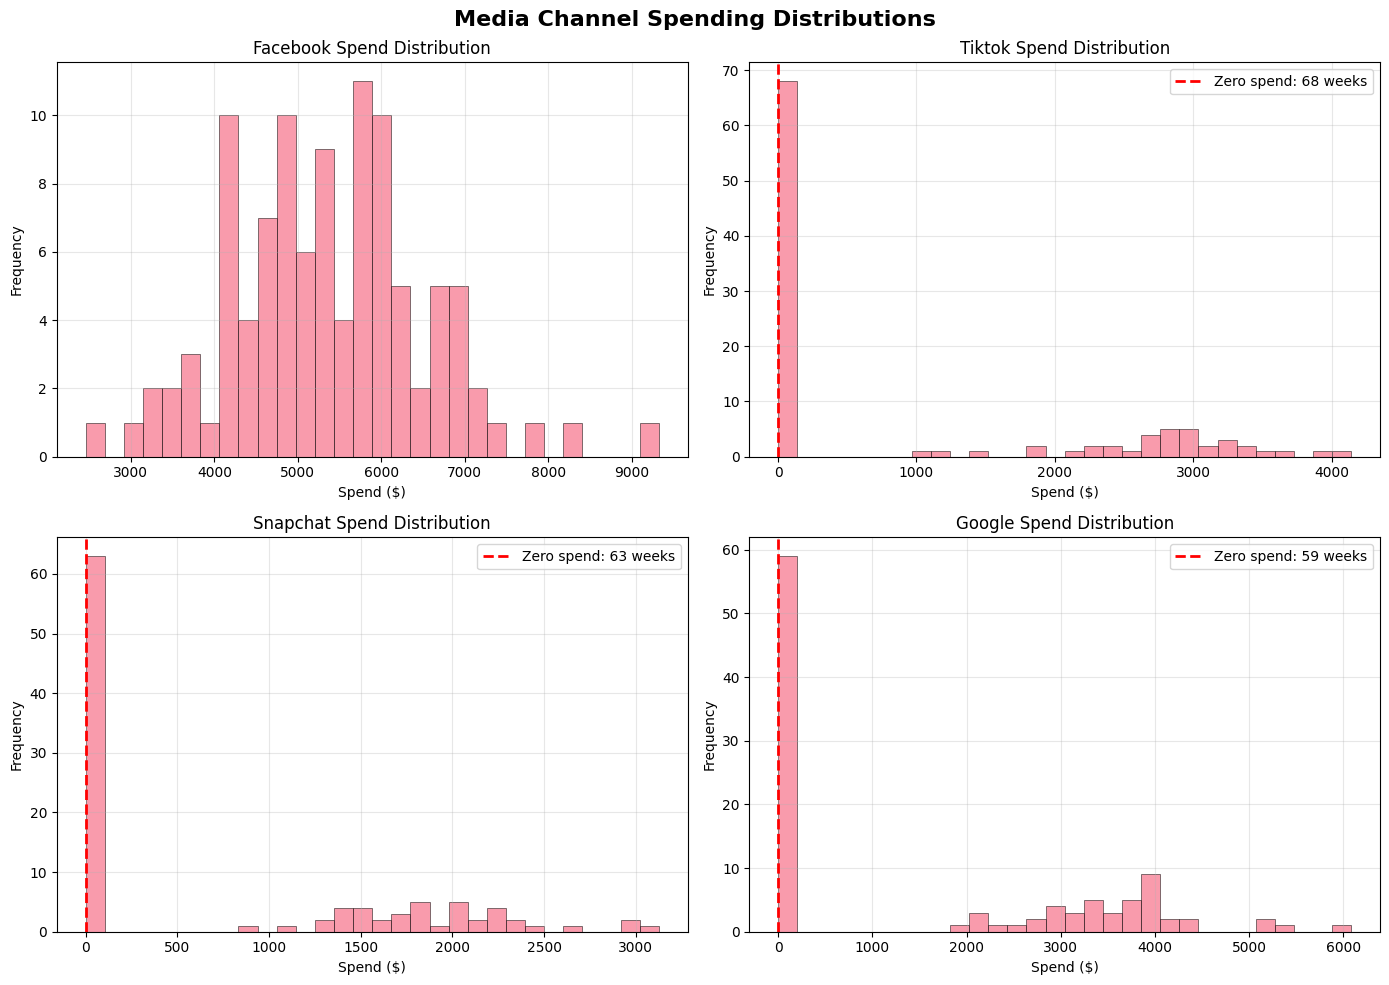

In [8]:
# Zero-spend analysis
print("=== ZERO-SPEND ANALYSIS ===")

zero_spend_summary = pd.DataFrame({
    'Channel': media_channels,
    'Total Weeks': [len(df)] * len(media_channels),
    'Zero Spend Weeks': [sum(df[channel] == 0) if channel in df.columns else 0 for channel in media_channels],
    'Zero Spend %': [sum(df[channel] == 0) / len(df) * 100 if channel in df.columns else 0 for channel in media_channels],
    'Min Spend': [df[channel].min() if channel in df.columns else 0 for channel in media_channels],
    'Max Spend': [df[channel].max() if channel in df.columns else 0 for channel in media_channels],
    'Avg Spend': [df[channel].mean() if channel in df.columns else 0 for channel in media_channels]
})

zero_spend_summary = zero_spend_summary.round(2)
print(zero_spend_summary.to_string(index=False))

# Visualize spending distributions
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Media Channel Spending Distributions', fontsize=16, fontweight='bold')

for i, channel in enumerate(media_channels):
    if channel in df.columns:
        row = i // 2
        col = i % 2
        
        # Histogram with zero-spend highlighted
        axes[row, col].hist(df[channel], bins=30, alpha=0.7, edgecolor='black', linewidth=0.5)
        
        # Highlight zero-spend if any
        zero_count = sum(df[channel] == 0)
        if zero_count > 0:
            axes[row, col].axvline(x=0, color='red', linestyle='--', linewidth=2, 
                                 label=f'Zero spend: {zero_count} weeks')
            axes[row, col].legend()
        
        axes[row, col].set_title(f'{channel.replace("_", " ").title()} Distribution')
        axes[row, col].set_xlabel('Spend ($)')
        axes[row, col].set_ylabel('Frequency')
        axes[row, col].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [9]:
# Spending consistency analysis
print("=== SPENDING CONSISTENCY ANALYSIS ===")

consistency_metrics = pd.DataFrame({
    'Channel': media_channels,
    'Mean': [df[channel].mean() if channel in df.columns else 0 for channel in media_channels],
    'Std Dev': [df[channel].std() if channel in df.columns else 0 for channel in media_channels],
    'CV (%)': [df[channel].std() / df[channel].mean() * 100 if channel in df.columns and df[channel].mean() > 0 else 0 for channel in media_channels],
    'Q25': [df[channel].quantile(0.25) if channel in df.columns else 0 for channel in media_channels],
    'Median': [df[channel].median() if channel in df.columns else 0 for channel in media_channels],
    'Q75': [df[channel].quantile(0.75) if channel in df.columns else 0 for channel in media_channels]
})

consistency_metrics = consistency_metrics.round(2)
print(consistency_metrics.to_string(index=False))

print("\nNotes:")
print("- CV (Coefficient of Variation) shows spending volatility")
print("- High CV indicates more variable spending patterns")
print("- Zero-spend periods provide natural experiments for incrementality")

=== SPENDING CONSISTENCY ANALYSIS ===
       Channel    Mean  Std Dev  CV (%)     Q25  Median     Q75
facebook_spend 5346.30  1168.96   21.86 4538.98 5293.78 6033.32
  tiktok_spend  955.63  1376.99  144.09    0.00    0.00 2487.17
snapchat_spend  747.46   982.09  131.39    0.00    0.00 1705.87
  google_spend 1543.87  1863.35  120.69    0.00    0.00 3374.20

Notes:
- CV (Coefficient of Variation) shows spending volatility
- High CV indicates more variable spending patterns
- Zero-spend periods provide natural experiments for incrementality


## 6. Correlation Analysis

Examine correlations between media channels and revenue to understand potential relationships and multicollinearity issues.

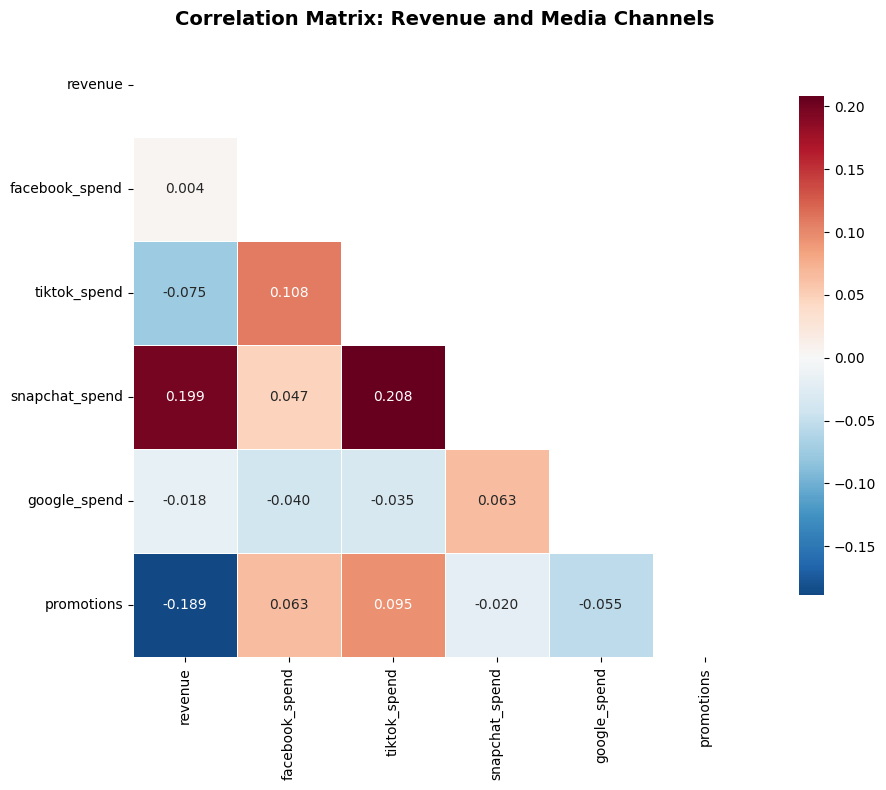

=== CORRELATIONS WITH REVENUE ===
snapchat_spend    0.199
promotions       -0.189
tiktok_spend     -0.075
google_spend     -0.018
facebook_spend    0.004
Name: revenue, dtype: float64

=== MEDIA CHANNEL INTERCORRELATIONS ===
Strong correlations (|r| > 0.5) between media channels:
  No strong correlations (|r| > 0.5) found between media channels


In [10]:
# Correlation analysis
correlation_vars = ['revenue'] + media_channels + (['promotions'] if 'promotions' in df.columns else [])
correlation_data = df[correlation_vars]

# Calculate correlation matrix
corr_matrix = correlation_data.corr()

# Create correlation heatmap
plt.figure(figsize=(10, 8))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))  # Mask upper triangle

sns.heatmap(corr_matrix, 
            mask=mask,
            annot=True, 
            fmt='.3f',
            cmap='RdBu_r',
            center=0,
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": .8})

plt.title('Correlation Matrix: Revenue and Media Channels', fontsize=14, fontweight='bold')
plt.tight_layout()
plt.show()

# Highlight strong correlations with revenue
print("=== CORRELATIONS WITH REVENUE ===")
revenue_corrs = corr_matrix['revenue'].drop('revenue').sort_values(key=abs, ascending=False)
print(revenue_corrs.round(3))

# Identify potential multicollinearity among media channels
print("\n=== MEDIA CHANNEL INTERCORRELATIONS ===")
media_corr = corr_matrix.loc[media_channels, media_channels]
print("Strong correlations (|r| > 0.5) between media channels:")

strong_corrs = []
for i in range(len(media_channels)):
    for j in range(i+1, len(media_channels)):
        if media_channels[i] in df.columns and media_channels[j] in df.columns:
            corr_val = media_corr.iloc[i, j]
            if abs(corr_val) > 0.5:
                strong_corrs.append(f"{media_channels[i]} ↔ {media_channels[j]}: {corr_val:.3f}")

if strong_corrs:
    for corr in strong_corrs:
        print(f"  {corr}")
else:
    print("  No strong correlations (|r| > 0.5) found between media channels")

## 7. Feature Engineering

Apply our feature engineering pipeline to create time features, adstock transformations, and saturation curves for modeling.

In [11]:
# Feature engineering using our custom module
print("=== FEATURE ENGINEERING ===")

# Apply feature engineering pipeline
try:
    # Use default parameters for adstock and saturation
    enhanced_df, feature_columns = build_features(
        df,
        saturation_method='hill',  # Use Hill saturation
        media_channels=media_channels
    )
    
    print(f"✓ Feature engineering completed successfully")
    print(f"Original columns: {len(df.columns)}")
    print(f"Enhanced columns: {len(enhanced_df.columns)}")
    print(f"New features created: {len(feature_columns)}")
    
except Exception as e:
    print(f"✗ Feature engineering failed: {e}")
    enhanced_df = df.copy()
    feature_columns = []

# Display the new feature columns
print(f"\n=== NEW FEATURE COLUMNS ({len(feature_columns)}) ===")
for i, col in enumerate(feature_columns, 1):
    print(f"{i:2d}. {col}")

2025-09-14 11:13:56,547 - INFO - Created time features based on column 'week'
2025-09-14 11:13:56,558 - INFO - Transformed facebook_spend: adstock(decay=0.5) + hill saturation
2025-09-14 11:13:56,564 - INFO - Transformed tiktok_spend: adstock(decay=0.5) + hill saturation
2025-09-14 11:13:56,571 - INFO - Transformed snapchat_spend: adstock(decay=0.5) + hill saturation
2025-09-14 11:13:56,578 - INFO - Transformed google_spend: adstock(decay=0.5) + hill saturation
2025-09-14 11:13:56,581 - INFO - Created promo_flag from promotions column
2025-09-14 11:13:56,581 - INFO - Created log_revenue from revenue column
2025-09-14 11:13:56,582 - INFO - Feature engineering complete. Created 15 new features.


=== FEATURE ENGINEERING ===
✓ Feature engineering completed successfully
Original columns: 12
Enhanced columns: 27
New features created: 15

=== NEW FEATURE COLUMNS (15) ===
 1. t
 2. weekofyear
 3. year
 4. week_sin
 5. week_cos
 6. facebook_spend_adstock
 7. facebook_spend_saturated
 8. tiktok_spend_adstock
 9. tiktok_spend_saturated
10. snapchat_spend_adstock
11. snapchat_spend_saturated
12. google_spend_adstock
13. google_spend_saturated
14. promo_flag
15. log_revenue


In [12]:
# Show examples of transformed features
if feature_columns:
    print("=== FEATURE TRANSFORMATION EXAMPLES ===")
    
    # Show time features
    time_features = ['t', 'weekofyear', 'year', 'week_sin', 'week_cos']
    available_time_features = [col for col in time_features if col in enhanced_df.columns]
    
    if available_time_features:
        print("\nTime Features (first 10 rows):")
        display(enhanced_df[['week'] + available_time_features].head(10))
    
    # Show media transformations for one channel (e.g., Facebook)
    facebook_cols = [col for col in enhanced_df.columns if 'facebook' in col.lower()]
    if facebook_cols:
        print(f"\nFacebook Transformations (first 10 rows):")
        display(enhanced_df[facebook_cols].head(10).round(3))
    
    # Show target variable transformations
    target_cols = [col for col in enhanced_df.columns if col in ['revenue', 'log_revenue', 'promo_flag']]
    if target_cols:
        print(f"\nTarget Variables (first 10 rows):")
        display(enhanced_df[target_cols].head(10))

=== FEATURE TRANSFORMATION EXAMPLES ===

Time Features (first 10 rows):


,week,t,weekofyear,year,week_sin,week_cos
0,2023-09-17,1,37,2023,-0.970942,-0.239316
1,2023-09-24,2,38,2023,-0.992709,-0.120537
2,2023-10-01,3,39,2023,-1.0,-0.0
3,2023-10-08,4,40,2023,-0.992709,0.120537
4,2023-10-15,5,41,2023,-0.970942,0.239316
5,2023-10-22,6,42,2023,-0.935016,0.354605
6,2023-10-29,7,43,2023,-0.885456,0.464723
7,2023-11-05,8,44,2023,-0.822984,0.568065
8,2023-11-12,9,45,2023,-0.748511,0.663123
9,2023-11-19,10,46,2023,-0.663123,0.748511



Facebook Transformations (first 10 rows):


,facebook_spend,facebook_spend_adstock,facebook_spend_saturated
0,6030.80,6030.800,1.0
1,5241.44,8256.840,1.0
2,5893.00,10021.420,1.0
3,7167.16,12177.870,1.0
4,5360.29,11449.225,1.0
5,4195.29,9919.902,1.0
6,4788.44,9748.391,1.0
7,6862.08,11736.276,1.0
8,5792.88,11661.018,1.0
9,5881.88,11712.389,1.0



Target Variables (first 10 rows):


,revenue,promo_flag,log_revenue
0,83124.16,0,11.328103
1,373.02,0,5.924309
2,513.01,0,6.242243
3,452.78,1,6.117612
4,41441.95,1,10.632073
5,141742.69,0,11.861776
6,42968.41,0,10.668244
7,1.00,0,0.693147
8,23117.23,0,10.048377
9,26904.34,0,10.200080


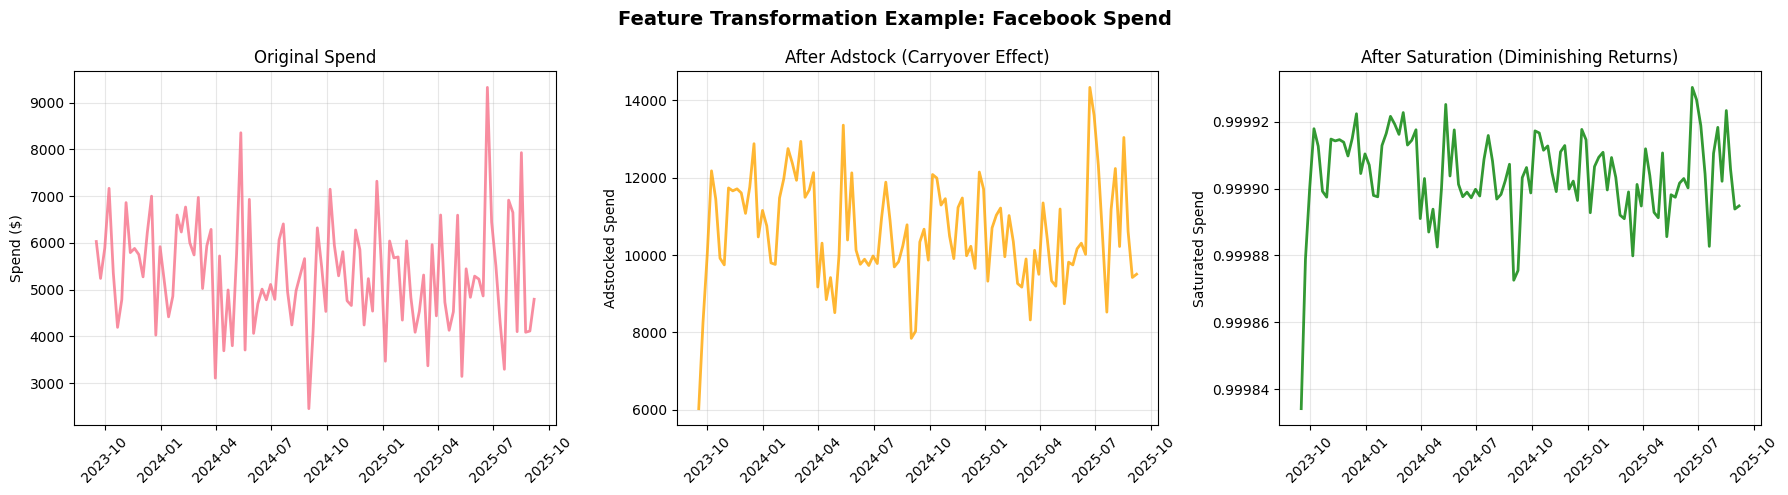

✓ Feature transformation plot displayed successfully

=== TRANSFORMATION EFFECTS FOR FACEBOOK_SPEND ===
Metric  Original  Adstocked  Saturated
  Mean   5346.30   10601.19        1.0
   Std   1168.96    1346.60        0.0
   Min   2456.94    6030.80        1.0
   Max   9325.18   14335.33        1.0


In [14]:
# Visualize adstock and saturation effects
if feature_columns:
    # Pick first media channel for demonstration
    demo_channel = None
    for channel in media_channels:
        if f"{channel}_adstock" in enhanced_df.columns and f"{channel}_saturated" in enhanced_df.columns:
            demo_channel = channel
            break
    
    if demo_channel:
        try:
            fig, axes = plt.subplots(1, 3, figsize=(18, 5))
            fig.suptitle(f'Feature Transformation Example: {demo_channel.replace("_", " ").title()}', 
                         fontsize=14, fontweight='bold')
            
            # Original spend
            axes[0].plot(enhanced_df['week'], enhanced_df[demo_channel], linewidth=2, alpha=0.8)
            axes[0].set_title('Original Spend')
            axes[0].set_ylabel('Spend ($)')
            axes[0].grid(True, alpha=0.3)
            axes[0].tick_params(axis='x', rotation=45)
            
            # Adstocked spend
            adstock_col = f"{demo_channel}_adstock"
            axes[1].plot(enhanced_df['week'], enhanced_df[adstock_col], linewidth=2, alpha=0.8, color='orange')
            axes[1].set_title('After Adstock (Carryover Effect)')
            axes[1].set_ylabel('Adstocked Spend')
            axes[1].grid(True, alpha=0.3)
            axes[1].tick_params(axis='x', rotation=45)
            
            # Saturated spend
            saturated_col = f"{demo_channel}_saturated"
            axes[2].plot(enhanced_df['week'], enhanced_df[saturated_col], linewidth=2, alpha=0.8, color='green')
            axes[2].set_title('After Saturation (Diminishing Returns)')
            axes[2].set_ylabel('Saturated Spend')
            axes[2].grid(True, alpha=0.3)
            axes[2].tick_params(axis='x', rotation=45)
            
            plt.tight_layout()
            
            # Save plot and display
            plt.savefig('../reports/feature_transformations.png', dpi=300, bbox_inches='tight')
            plt.show()
            
            print("✓ Feature transformation plot displayed successfully")
            
        except Exception as e:
            print(f"⚠ Error creating transformation plot: {e}")
            print("Continuing with statistical summary...")
        
        # Show transformation statistics
        print(f"\n=== TRANSFORMATION EFFECTS FOR {demo_channel.upper()} ===")
        try:
            transform_stats = pd.DataFrame({
                'Metric': ['Mean', 'Std', 'Min', 'Max'],
                'Original': [enhanced_df[demo_channel].mean(), enhanced_df[demo_channel].std(), 
                            enhanced_df[demo_channel].min(), enhanced_df[demo_channel].max()],
                'Adstocked': [enhanced_df[adstock_col].mean(), enhanced_df[adstock_col].std(),
                             enhanced_df[adstock_col].min(), enhanced_df[adstock_col].max()],
                'Saturated': [enhanced_df[saturated_col].mean(), enhanced_df[saturated_col].std(),
                             enhanced_df[saturated_col].min(), enhanced_df[saturated_col].max()]
            })
            print(transform_stats.round(2).to_string(index=False))
            
        except Exception as e:
            print(f"⚠ Error computing transformation statistics: {e}")
    
    else:
        print("⚠ No media channels with both adstock and saturation transformations found")
        print("Available transformed columns:")
        transformed_cols = [col for col in enhanced_df.columns if any(suffix in col for suffix in ['_adstock', '_saturated'])]
        for col in transformed_cols[:10]:  # Show first 10
            print(f"  - {col}")
else:
    print("⚠ No feature columns available for transformation visualization")

## 8. Data Export and Summary

Save the processed dataset and provide a summary of findings for the next modeling phase.

In [15]:
# Save processed data
output_path = "../data/processed_weekly_data.csv"
enhanced_df.to_csv(output_path, index=False)
print(f"✓ Processed data saved to: {output_path}")

# Save feature list for reference
feature_list_path = "../data/feature_columns.txt"
with open(feature_list_path, 'w') as f:
    f.write("Feature columns created by build_features():\n")
    for i, col in enumerate(feature_columns, 1):
        f.write(f"{i}. {col}\n")

print(f"✓ Feature list saved to: {feature_list_path}")

# Final dataset summary
print("\n=== FINAL DATASET SUMMARY ===")
print(f"Final dataset shape: {enhanced_df.shape}")
print(f"Date range: {enhanced_df['week'].min()} to {enhanced_df['week'].max()}")
print(f"Total weeks: {len(enhanced_df)}")
print(f"Original features: {len(df.columns)}")
print(f"Engineered features: {len(feature_columns)}")
print(f"Total features: {len(enhanced_df.columns)}")

# Check data quality
missing_final = enhanced_df.isnull().sum().sum()
print(f"Missing values in final dataset: {missing_final}")

if missing_final == 0:
    print("✓ Dataset ready for modeling")
else:
    print("⚠ Review missing values before modeling")

✓ Processed data saved to: ../data/processed_weekly_data.csv
✓ Feature list saved to: ../data/feature_columns.txt

=== FINAL DATASET SUMMARY ===
Final dataset shape: (104, 27)
Date range: 2023-09-17 00:00:00 to 2025-09-07 00:00:00
Total weeks: 104
Original features: 12
Engineered features: 15
Total features: 27
Missing values in final dataset: 0
✓ Dataset ready for modeling


## Key Findings Summary

Based on the EDA and feature preparation:

### Data Quality
- **Dataset shape**: Complete weekly time series data
- **Missing values**: Check output above
- **Date range**: Review the time span covered

### Time Series Patterns
- **Revenue trends**: Examine the revenue plot for growth patterns
- **Media spending**: Note the variability and patterns in channel spending
- **Seasonality**: Weekly patterns identified through decomposition

### Media Channel Insights
- **Zero-spend periods**: Natural experiments for incrementality measurement
- **Spending consistency**: Channel volatility varies (check CV values)
- **Correlations**: Review correlations with revenue and between channels

### Feature Engineering
- **Time features**: Created cyclical and trend features for seasonality
- **Adstock transformation**: Applied carryover effects to media channels
- **Saturation curves**: Applied diminishing returns transformation
- **Target variables**: Created log-transformed revenue and promotion flags

### Next Steps
The dataset is now ready for modeling in `02_modeling_iv_elasticnet_xgb.ipynb`
